In [47]:
#from matplotlib import font_manager
#a = sorted([f.name for f in font_manager.fontManager.ttflist])
#for i in a:
#    print(i)

In [1]:
import tensorflow as tf 
import numpy as np
from Bio import SeqIO
import json
from sklearn.model_selection import train_test_split
import feature as fe 
import copy 
from tensorflow.keras import *
import seaborn as sns 
import matplotlib
import matplotlib.pyplot as plt 
import pandas as pd 

from sklearn import metrics
matplotlib.rcParams['font.family']='Heiti TC'#修改了全局变量

%matplotlib inline 
%config InlineBackend.figure_format = 'jpg' #以矢量图的形式显示图片，这样比较清晰
plt.style.use({'figure.figsize':(20,16)})



def drawMetrics(y_true,y_pred,modelName = 'unknown'):
    out = []
    for threshold in [i/100 for i in range(100)]:
        index= metricsIndex(y_true,y_pred,threshold)
        out.append(index)
    out = np.array(out)
    modelMetrics = pd.DataFrame(out,columns=['MCC','ACC','Sensitivity','Specificity'])
    modelMetrics.plot()
    plt.legend(loc='upper left',fontsize=15)
    plt.title(modelName+'模型的MCC，准确性，敏感性和特异性随阈值的变化曲线图',fontsize=15)
    #plt.savefig(modelName+'模型的MCC，准确性，敏感性和特异性随阈值的变化曲线图'+'.jpg',dpi=500)

def drawlossinTwoSet(data,modelname='未知'):
    y1 = data.history['loss']
    y2 = data.history['val_loss']
    x = range(len(y1))
    #modelname= 'TotalFeaturesmodel'
    filename = modelname+'loss'

    sns.lineplot(x =x  ,y=y1)
    plt.xticks(ticks=x,labels=['epoch'+ str(i+1)for i in x],fontsize=1)
    #for i,j in zip(x,y1):
        #plt.text(i,j+0.005*j,'loss={:.2}'.format(j),fontsize=12)
    #plt.hlines(max(y1),x[-20],x[-1])
    plt.text(x[-9],max(y1),'train_loss= {:.5}'.format(max(y1)),fontsize=14)

    sns.lineplot(x=x,y=y2,color='b')

    plt.text(x[-9],np.median(y2),'val_loss= {:.5}'.format(np.median(y2)),fontsize=14)

    #for i,j in zip(x,y2):
        #plt.text(i,j-0.01*j,'loss={:.2}'.format(j),color = 'b',fontsize=12)
    plt.title('牛奶过敏BCEs'+modelname+'模型训练loss结果图',fontsize=30)    

    plt.legend(['训练集','测试集'],loc='upper left',fontsize=30)
    #plt.savefig(filename+'.jpg',dpi=500)

def drawACCinTwoSet(data,modelname='未知'):
    y1 = data.history['acc']
    y2 = data.history['val_acc']
    x = range(len(y1))
    #modelname= 'TotalFeaturesmodel'
    filename = modelname+'ACC'

    sns.lineplot(x =x  ,y=y1)
    plt.xticks(ticks=x,labels=['epoch'+ str(i+1)for i in x],fontsize=1)
    #for i,j in zip(x,y1):
        #plt.text(i,j+0.005*j,'acc={:.2}'.format(j),fontsize=12)
    #plt.hlines(max(y1),x[-20],x[-1])
    plt.text(x[-9],max(y1),'train_acc= {:.5}'.format(max(y1)),fontsize=14)

    sns.lineplot(x=x,y=y2,color='b')

    plt.text(x[-9],np.median(y2),'val_acc= {:.5}'.format(np.median(y2)),fontsize=14)

    #for i,j in zip(x,y2):
        #plt.text(i,j-0.01*j,'acc={:.2}'.format(j),color = 'b',fontsize=12)
    plt.title('牛奶过敏BCEs'+modelname+'模型训练acc结果图',fontsize=30)    

    plt.legend(['训练集','测试集'],loc='upper left',fontsize=30)
    #plt.savefig(filename+'.jpg',dpi=500)
    
def applynumpyArray1D(arr,func):
    """
    
    """
    array = copy.deepcopy(arr)  
    for i in range(array.shape[0]):
        array[i] = func(array[i])
    return array

def normize(array):
    """
    input: np.array shape = (n,) 一维向量 
    output: 对 输入的数据进行归一化，即 (a_i - a.mean())/a.std  若全为0，则返回原array。
    
    """
    temp = copy.deepcopy(array)
    if (array == 0).all():#应当添加()
        normizedarray = temp
    else:
        normizedarray = (temp-temp.mean())/temp.std()
    return normizedarray
def twoDArraynormize(twoDArray):
    """
    input: np.array, shape = (n,m)  n为样本个数，m为特征个数，  对每一个样本的同一个特征进行归一化处理即 (m_i - m's mean)/m'std
    output: np.array, shape = (n,m) n为样本个数，m为特征个数。 归一化后的结果 

    """
    temp = copy.deepcopy(twoDArray)
    for i in range(temp.shape[1]):
        array = temp[:,i]
        temp[:,i] = normize(array)
    return temp    
    

#词向量化
def amino_acids2numvector(sequenceArray,toknizer):
    """
    input:
        sequence:(n,) np.array类型，多肽序列
        toknizer: 氨基酸toknizer。    
    output:（n,200) 数字化后的多肽序列
    """
    sequenceArray = applynumpyArray1D(sequenceArray,lambda x: ' '.join(x))
    sequenceArray = toknizer.texts_to_sequences(sequenceArray)
    #选取最常长度为20
    sequenceArray = tf.keras.preprocessing.sequence.pad_sequences(sequenceArray,truncating='post',padding='post',maxlen=20)
    return sequenceArray


#AAC Matrix
def aminoacids2AACMatrix(array):
    """
    
    """
    tmp = copy.deepcopy(array)
    tmp = applynumpyArray1D(tmp,fe.CalculateAAComposition)
    AACMatrix = applynumpyArray1D(tmp,lambda x: [i for i in x.values()])#输出是（n,)的shape
    #转化为np.array，shape为（n,20）
    AACMatrix = np.array(AACMatrix.tolist())
    return AACMatrix

#DPC Matrix
#DPC Matrix
def aminoacids2DPCMatrix(array):
    """
    
    """
    tmp = copy.deepcopy(array)
    tmp = applynumpyArray1D(tmp,fe.CalculateDipeptideComposition)
    DPCMatrix = applynumpyArray1D(tmp,lambda x: [i for i in x.values()])#输出是（n,)的shape
    #转化为np.array，shape为（n,20）
    DPCMatrix = np.array(DPCMatrix.tolist())
    return DPCMatrix

#CTD Matrix
def aminoacids2CTDMatrix(array):
    """
    
    """
    tmp = copy.deepcopy(array)
    tmp = applynumpyArray1D(tmp,fe.CalculateCTD)
    CTDMatrix = applynumpyArray1D(tmp,lambda x: [i for i in x.values()])#输出是（n,)的shape
    #转化为np.array，shape为（n,20）
    CTDMatrix = np.array(CTDMatrix.tolist())
    return CTDMatrix
#AAI Matrix
def aminoacids2AAIMatrix(array):
    """
    
    """
    tmp = copy.deepcopy(array)
    tmp = applynumpyArray1D(tmp,fe.CalculateAAIndex)
    AAIMatrix = applynumpyArray1D(tmp,lambda x: [i for i in x.values()])#输出是（n,)的shape
    #转化为np.array，shape为（n,20）
    AAIMatrix = np.array(AAIMatrix.tolist())
    return AAIMatrix


def generateFeaturesData(sequenceData,normize=False):
    """
    input:
        sequence:(n,) np.array类型，包含n条多肽序列的数组
    output:[AAC,DPC,CTD,AAI,SeqVec]的一个列表
    """
    data = copy.deepcopy(sequenceData)
    AAC = aminoacids2AACMatrix(data)
    if normize:
        AAC = twoDArraynormize(AAC)
    
    DPC = aminoacids2DPCMatrix(data)
    if normize:
        DPC = twoDArraynormize(DPC)
    
    CTD = aminoacids2CTDMatrix(data)
    if normize:
        CTD = twoDArraynormize(CTD)
    
    AAI = aminoacids2AAIMatrix(data)
    #if normize:
    AAI = twoDArraynormize(AAI)
    
    SeqVec = amino_acids2numvector(data,toknizer)
    return [AAC,DPC,CTD,AAI,SeqVec]



def metricsEvaluate(y_true,y_pred,p_threshold):
    """
    input:
        y_pred:模型的预测概率，是一个np.array的数组，函数会对预测概率根据制定的预测阈值指定分类
        y_true:数据的真实分类，是一个np.array的数组
        p_threshold:指定分类阈值，大于这个值会分类为1，小于会分类为0
    output:[Sensitivity,Specificity,MCC]
    
    """
    y_pred = copy.deepcopy(y_pred)
    y_pred[y_pred>=p_threshold]=1
    y_pred[y_pred<=p_threshold]=0
    confusion_matrix = metrics.confusion_matrix(y_true=y_true,y_pred = y_pred)
    tn, fp, fn, tp = confusion_matrix.ravel()
    Sensitivity = tp/(tp+fn)
    Specificity = tn/(tn+fp)
    MCC = metrics.matthews_corrcoef(y_true,y_pred)
    ACC = metrics.accuracy_score(y_true,y_pred)
    print('模型的ACC为:{:.2f},\n模型的敏感性为:{:.2f},\n特异性为:{:.2f},\nMCC系数为:{:.2f}'.format(ACC,Sensitivity,Specificity,MCC))
    return [ACC,Sensitivity,Specificity,MCC]

def metricsIndex(y_true,y_pred,p_threshold):
    """
    input:
        y_pred:模型的预测概率，是一个np.array的数组，函数会对预测概率根据制定的预测阈值指定分类
        y_true:数据的真实分类，是一个np.array的数组
        p_threshold:指定分类阈值，大于这个值会分类为1，小于会分类为0
    output:[Sensitivity,Specificity,MCC]
    
    """
    y_pred = copy.deepcopy(y_pred)
    y_pred[y_pred>=p_threshold]=1
    y_pred[y_pred<=p_threshold]=0
    confusion_matrix = metrics.confusion_matrix(y_true=y_true,y_pred = y_pred)
    tn, fp, fn, tp = confusion_matrix.ravel()
    Sensitivity = tp/(tp+fn)
    Specificity = tn/(tn+fp)
    MCC = metrics.matthews_corrcoef(y_true,y_pred)
    ACC = metrics.accuracy_score(y_true,y_pred)
    return [MCC,ACC,Sensitivity,Specificity]

def PCA(X,k):
    """
    input：
        X：原数据，np.array类型，shape=(n,m),n为样本数目，m为维度
        k：降低到多少维
    output:
        Y：降维后的数据，shape=(n,k)
    """
    number = X.shape[0]
    dimension = X.shape[1]
    X = X - X.mean(axis=0)
    C = np.dot(X.T,X)/number
    
    eig_val,eig_vec = np.linalg.eig(C)
    
    eig_List = [(np.abs(eig_val[i]),eig_vec[:,i]) for i in range(dimension)]
    try:
        eig_List.sort(reverse=True)
        P = np.array([each_List[1] for each_List in eig_List[:k]])
        Y = np.dot(X,P.T)
        return Y 
    except:
        print('出现特征值相同的情况啦，该代码无法继续运行下去，换用其他方式进行PCA处理！')
        return eig_List

## 数据读入

In [2]:
#读取 词分类器
with open('tfsModel/RNNamino_acids_toknizer.json','r') as f:
    toknizer =tf.keras.preprocessing.text.tokenizer_from_json(json.load(f))

B_positiveFeatures = [AAC,DPC,CTD,AAI,Seq]

B_negativeFeatures = [AAC,DPC,CTD,AAI,Seq]

milkAllergyBCEsFeatures = [AAC,DPC,CTD,AAI,Seq]

milkAllergynonBCEsFeatures = [AAC,DPC,CTD,AAI,Seq]

In [3]:
#标准化
#from sklearn import preprocessing

#scalerAAI = preprocessing.StandardScaler().fit(aminoacids2AAIMatrix(B_positive))

#AAInormized = scalerAAI.transform(aminoacids2AAIMatrix(B_positive))

In [5]:
#IBCE-EL的数据集
B_positive = pd.read_csv('IBCE_EL_B_positive.csv')['0'].values
B_negative = pd.read_csv('IBCE_EL_B_negative.csv')['0'].values
B_positiveFeatures = generateFeaturesData(B_positive)
B_negativeFeatures = generateFeaturesData(B_negative)
IBCE_ELTargets = np.concatenate([np.ones((B_positive.shape[0],)),np.zeros((B_negative.shape[0],))])

#牛奶过敏数据集
milkAllergyBCEs = pd.read_csv('milk allergy linear BCEs bovine dataset.csv')['Description'].values
milkAllergynonBCEs = pd.read_csv('milk allergy linear non-BCEs experiece confirmed.csv')['Description'].values
milkAllergyBCEsFeatures = generateFeaturesData(milkAllergyBCEs)
milkAllergynonBCEsFeatures = generateFeaturesData(milkAllergynonBCEs)
milkAllergyTargets = np.concatenate([np.ones((milkAllergyBCEsFeatures[0].shape[0],)),np.zeros((milkAllergynonBCEsFeatures[0].shape[0],))])
#milkAllergyTargets = np.ones((milkAllergyBCEsFeatures[0].shape[0],))


In [12]:
milkAllergyBCEs.shape,milkAllergyTargets.shape

((238,), (464,))

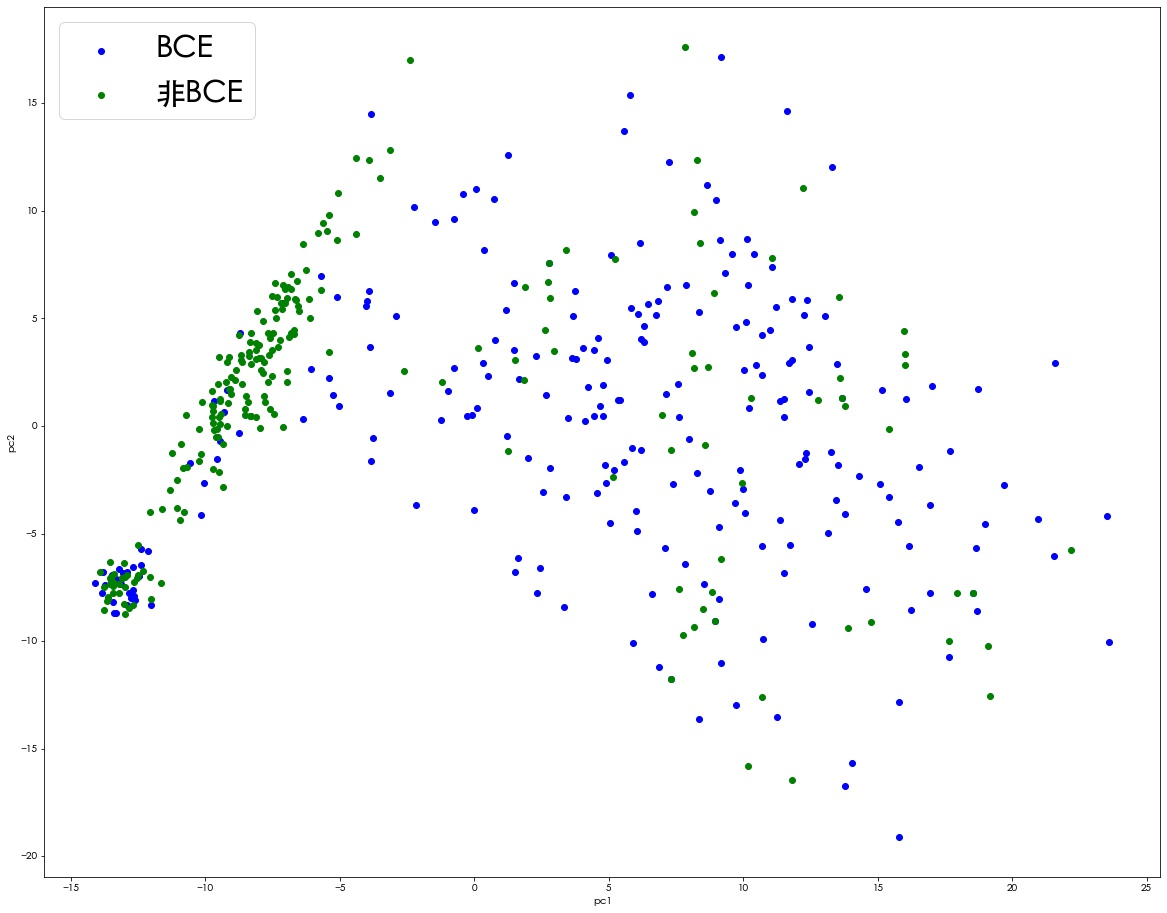

In [19]:
#PCA分析
i=4
x=np.concatenate([milkAllergyBCEsFeatures[i],milkAllergynonBCEsFeatures[i]])
X_trans = PCA(x,2)
x1 = X_trans[:, 0]
x2 = X_trans[:, 1]
#绘图
plt.scatter(x1[:238], x2[:238], c='b')
plt.scatter(x1[238:464], x2[238:464], c='g')
plt.legend(['BCE','非BCE'],loc='upper left',fontsize=30)
plt.xlabel('pc1')
plt.ylabel('pc2')
plt.show()             
                 

## 模型读取

In [6]:
#读取基于IBCE-EL数据集构建的模型
IBCE_ELAACModel = tf.keras.models.load_model('tfsModel/IBCE_ELAACModel.h5')
IBCE_ELDPCModel = tf.keras.models.load_model('tfsModel/IBCE_ELDPCModel.h5')
IBCE_ELCTDModel = tf.keras.models.load_model('tfsModel/IBCE_ELCTDModel.h5')
IBCE_ELAAIModel = tf.keras.models.load_model('tfsModel/IBCE_ELAAIModel.h5')
IBCE_ELRNNModel = tf.keras.models.load_model('tfsModel/IBCE_ELRNNModel.h5')
IBCE_ELEMModel1 = tf.keras.models.load_model('tfsModel/EM_AAC_DPC_CTD_AAInomized_RNN_IBCE_EL.h5')
IBCE_ELEMModel2 = tf.keras.models.load_model('tfsModel/EM_AAC_DPC_CTD_AAInomized_IBCE_EL.h5')

In [20]:
#读取牛奶过敏数据训练的模型

#读取模型
Milk_AACModel = tf.keras.models.load_model('tfsModel/AACModel.h5')
Milk_DPCModel = tf.keras.models.load_model('tfsModel/DPCModel.h5')
Milk_CTDModel = tf.keras.models.load_model('tfsModel/CTDModel.h5')
Milk_AAIModel = tf.keras.models.load_model('tfsModel/AAIModelnormized.h5')
Milk_RNNModel = tf.keras.models.load_model('tfsModel/RNNModel.h5')
Milk_EMModel1 = tf.keras.models.load_model('tfsModel/EM_AAC_DPC_CTD_AAInomized_RNN.h5')
Milk_EMModel2 = tf.keras.models.load_model('tfsModel/EM_AAC_DPC_CTD_AAInomized.h5')


### 对基于IBCE-EL的模型进行评估

In [8]:
import IEDBdo as IEDB
IBCE_Positive = IEDB.readSeqFromeFasta('IBCE/Ind-positive.txt')
IBCE_Negative = IEDB.readSeqFromeFasta('IBCE/Ind-negative.txt')

In [13]:
IBCE_PositiveFeatures = generateFeaturesData(IBCE_Positive)
IBCE_NegativeFeatures = generateFeaturesData(IBCE_Negative)

IBCE_ELTargets = np.concatenate([np.ones((IBCE_PositiveFeatures[0].shape[0],)),np.zeros((IBCE_NegativeFeatures[0].shape[0],))])

In [14]:

#测试单个模型的性能
## 在IBCE-EL独立数据集上的效果
IBCE_ELAACModel.evaluate(x=np.concatenate([IBCE_PositiveFeatures[0],IBCE_NegativeFeatures[0]]),
                 y = IBCE_ELTargets,batch_size=64)

IBCE_ELDPCModel.evaluate(x=np.concatenate([IBCE_PositiveFeatures[1],IBCE_NegativeFeatures[1]]),
                 y = IBCE_ELTargets,batch_size=64)

IBCE_ELCTDModel.evaluate(x=np.concatenate([IBCE_PositiveFeatures[2],IBCE_NegativeFeatures[2]]),
                 y = IBCE_ELTargets,batch_size=64)

IBCE_ELAAIModel.evaluate(x=np.concatenate([IBCE_PositiveFeatures[3],IBCE_NegativeFeatures[3]]),
                 y = IBCE_ELTargets,batch_size=64)

IBCE_ELRNNModel.evaluate(x=np.concatenate([IBCE_PositiveFeatures[4],IBCE_NegativeFeatures[4]]),
                 y = IBCE_ELTargets,batch_size=64)


40/40 [==============================] - 1s 4ms/step - loss: 0.6499 - acc: 0.6700 - auc_4: 0.7014


[0.6499413847923279, 0.6699761748313904, 0.7014319896697998]

In [21]:
##对牛奶过敏模型进行预测
IBCE_ELAACModel.evaluate(x=np.concatenate([milkAllergyBCEsFeatures[0],milkAllergynonBCEsFeatures[0]]),
                 y = milkAllergyTargets,batch_size=16)

IBCE_ELDPCModel.evaluate(x=np.concatenate([milkAllergyBCEsFeatures[1],milkAllergynonBCEsFeatures[1]]),
                 y = milkAllergyTargets,batch_size=16)

IBCE_ELCTDModel.evaluate(x=np.concatenate([milkAllergyBCEsFeatures[2],milkAllergynonBCEsFeatures[2]]),
                 y = milkAllergyTargets,batch_size=16)

IBCE_ELAAIModel.evaluate(x=np.concatenate([milkAllergyBCEsFeatures[3],milkAllergynonBCEsFeatures[3]]),
                 y = milkAllergyTargets,batch_size=16)
IBCE_ELRNNModel.evaluate(x=np.concatenate([milkAllergyBCEsFeatures[4],milkAllergynonBCEsFeatures[4]]),
                 y = milkAllergyTargets,batch_size=16)

29/29 [==============================] - 1s 2ms/step - loss: 0.7792 - acc: 0.5517 - auc_4: 0.5677


[0.7792423367500305, 0.5517241358757019, 0.5677288770675659]

In [27]:
###对单个模型的预测输出作为EM模型的输入
####生成IBCE-EL的5类模型输出
IBCE_ELAACProb = IBCE_ELAACModel.predict(x=np.concatenate([IBCE_PositiveFeatures[0],IBCE_NegativeFeatures[0]]))

IBCE_ELDPCProb = IBCE_ELDPCModel.predict(x=np.concatenate([IBCE_PositiveFeatures[1],IBCE_NegativeFeatures[1]]))

IBCE_ELCTDProb = IBCE_ELCTDModel.predict(x=np.concatenate([IBCE_PositiveFeatures[2],IBCE_NegativeFeatures[2]]))

IBCE_ELAAIProb = IBCE_ELAAIModel.predict(x=np.concatenate([IBCE_PositiveFeatures[3],IBCE_NegativeFeatures[3]]))

IBCE_ELRNNProb = IBCE_ELRNNModel.predict(x=np.concatenate([IBCE_PositiveFeatures[4],IBCE_NegativeFeatures[4]]))

IBCE_ELAAC在IBCE-EL数据集上的评估结果
模型的ACC为:0.55,
模型的敏感性为:0.58,
特异性为:0.54,
MCC系数为:0.11


/Users/xutingfeng/opt/anaconda3/envs/Bio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


IBCE_ELDPC在IBCE-EL数据集上的评估结果
模型的ACC为:0.58,
模型的敏感性为:0.71,
特异性为:0.48,
MCC系数为:0.19


/Users/xutingfeng/opt/anaconda3/envs/Bio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


IBCE_ELCTD在IBCE-EL数据集上的评估结果
模型的ACC为:0.59,
模型的敏感性为:0.28,
特异性为:0.83,
MCC系数为:0.13


/Users/xutingfeng/opt/anaconda3/envs/Bio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


IBCE_ELAAI在IBCE-EL数据集上的评估结果
模型的ACC为:0.73,
模型的敏感性为:0.71,
特异性为:0.75,
MCC系数为:0.46


/Users/xutingfeng/opt/anaconda3/envs/Bio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


IBCE_ELRNN在IBCE-EL数据集上的评估结果
模型的ACC为:0.67,
模型的敏感性为:0.62,
特异性为:0.71,
MCC系数为:0.33


/Users/xutingfeng/opt/anaconda3/envs/Bio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


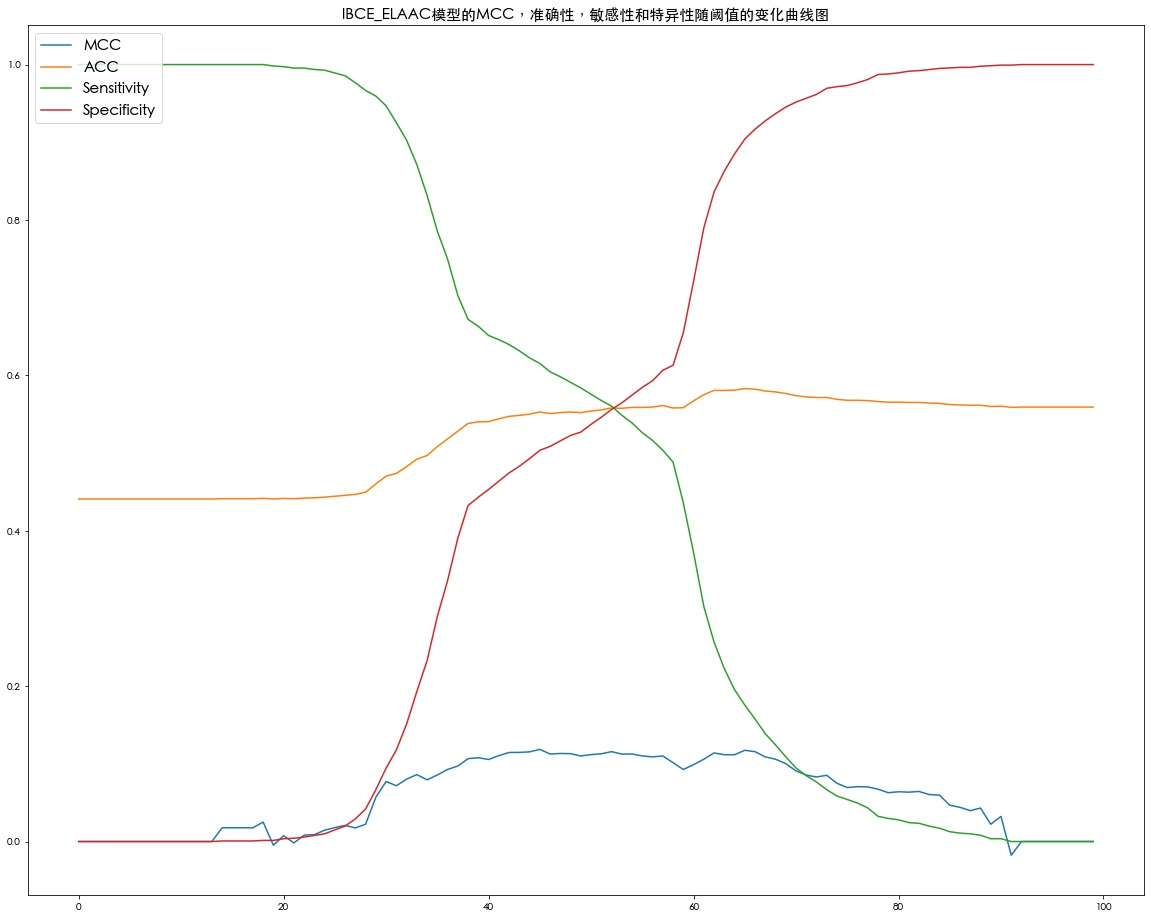

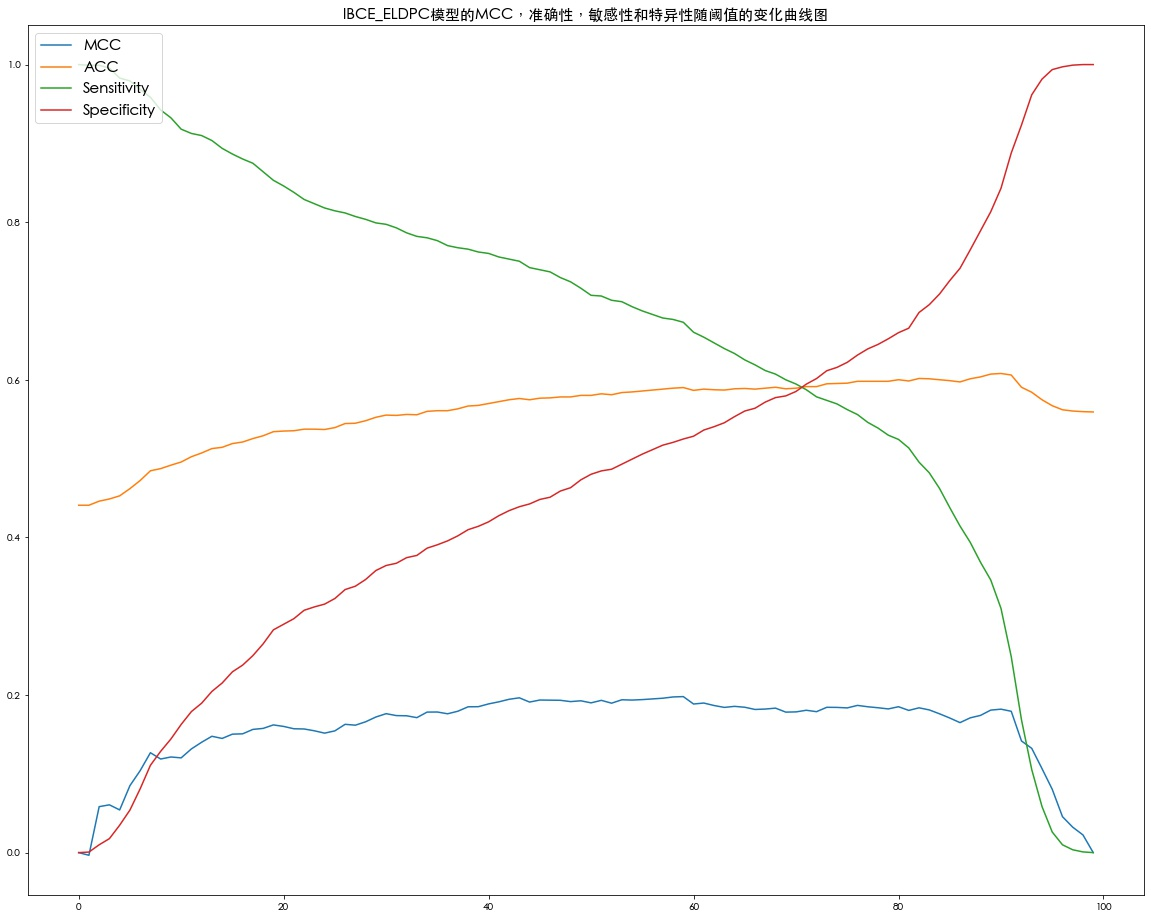

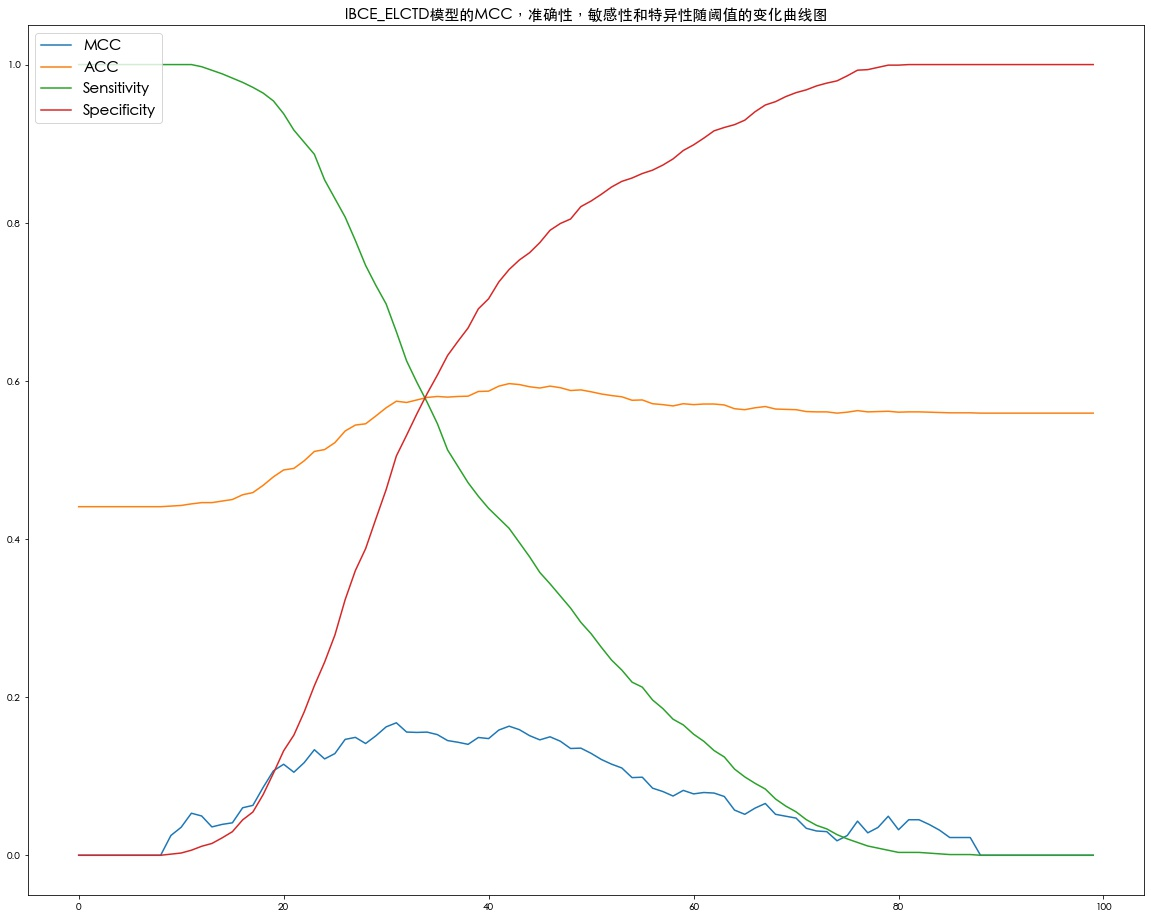

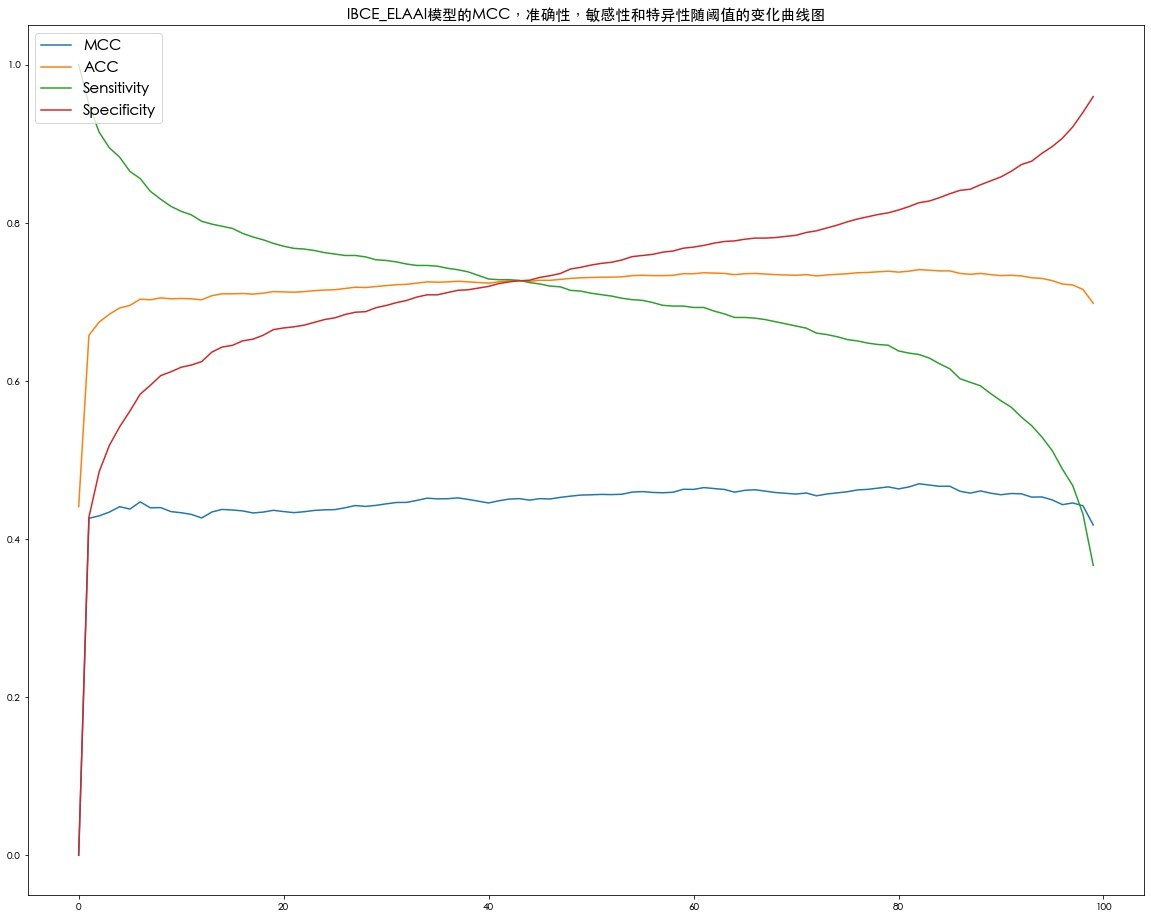

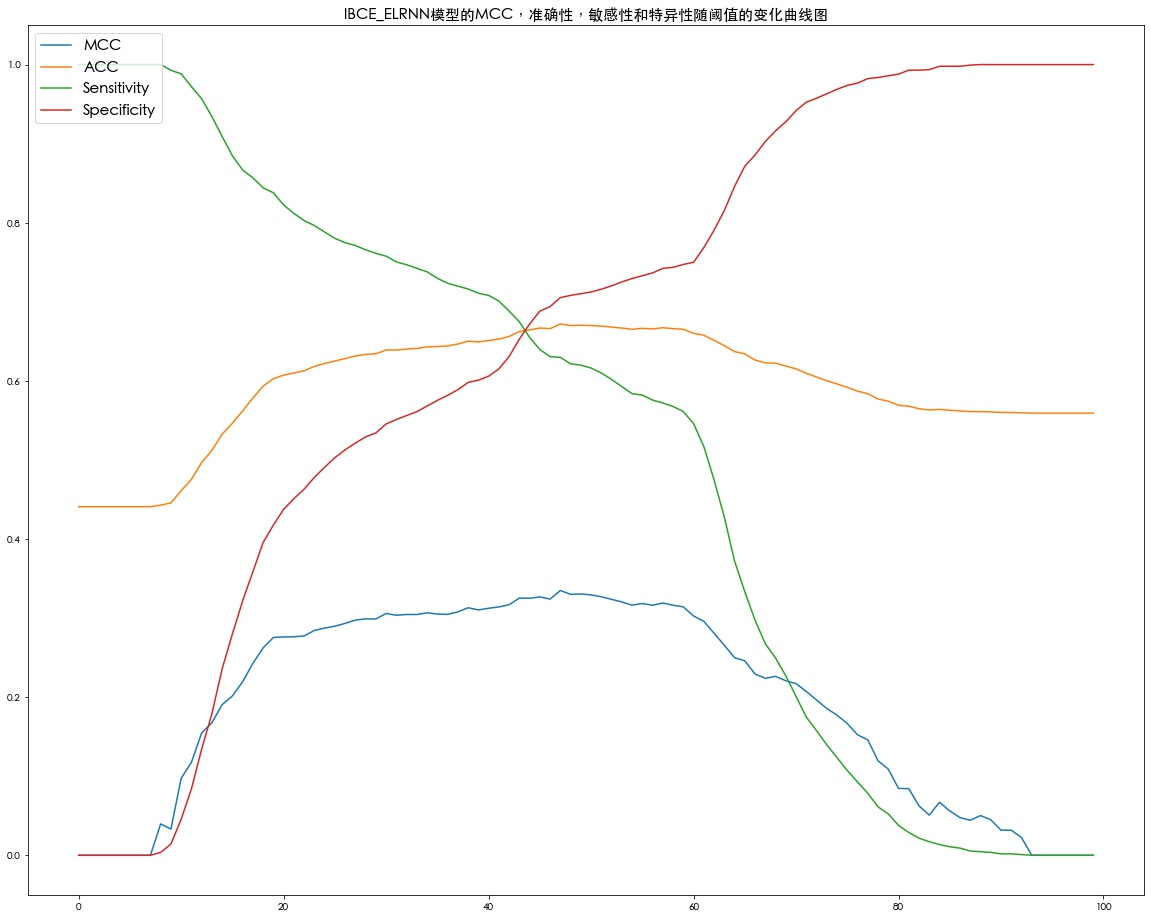

In [16]:
print('IBCE_ELAAC在IBCE-EL数据集上的评估结果')
metricsEvaluate(IBCE_ELTargets,IBCE_ELAACProb,0.5)
drawMetrics(IBCE_ELTargets,IBCE_ELAACProb,'IBCE_ELAAC')
print('IBCE_ELDPC在IBCE-EL数据集上的评估结果')
metricsEvaluate(IBCE_ELTargets,IBCE_ELDPCProb,0.5)
drawMetrics(IBCE_ELTargets,IBCE_ELDPCProb,'IBCE_ELDPC')
print('IBCE_ELCTD在IBCE-EL数据集上的评估结果')
metricsEvaluate(IBCE_ELTargets,IBCE_ELCTDProb,0.5)
drawMetrics(IBCE_ELTargets,IBCE_ELCTDProb,'IBCE_ELCTD')
print('IBCE_ELAAI在IBCE-EL数据集上的评估结果')
metricsEvaluate(IBCE_ELTargets,IBCE_ELAAIProb,0.5)
drawMetrics(IBCE_ELTargets,IBCE_ELAAIProb,'IBCE_ELAAI')
print('IBCE_ELRNN在IBCE-EL数据集上的评估结果')
metricsEvaluate(IBCE_ELTargets,IBCE_ELRNNProb,0.5)
drawMetrics(IBCE_ELTargets,IBCE_ELRNNProb,'IBCE_ELRNN')

/Users/xutingfeng/opt/anaconda3/envs/Bio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Text(0.5, 1.0, 'IBCE_ELRNN模型的MCC，准确性，敏感性和特异性随阈值的变化曲线图')

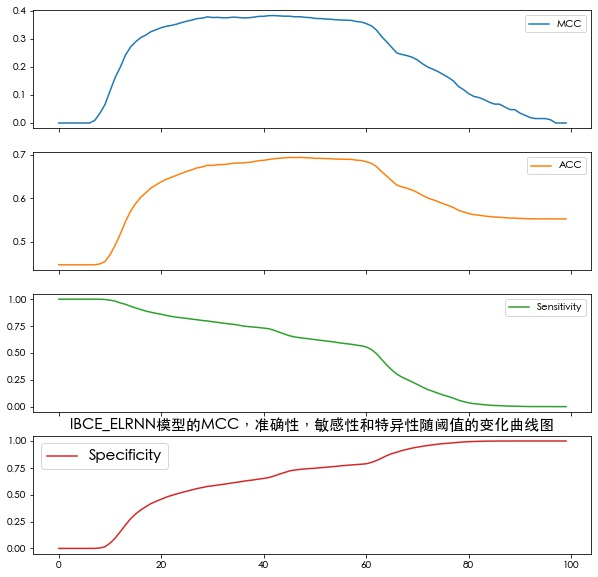

In [14]:
y_true =IBCE_ELTargets
y_pred = IBCE_ELRNNProb
modelName='IBCE_ELRNN'
#def drawMetrics(y_true,y_pred,modelName = 'unknown'):
out = []
for threshold in [i/100 for i in range(100)]:
    index= metricsIndex(y_true,y_pred,threshold)
    out.append(index)
out = np.array(out)
modelMetrics = pd.DataFrame(out,columns=['MCC','ACC','Sensitivity','Specificity'])
modelMetrics.plot()
plt.legend(loc='upper left',fontsize=15)
plt.title(modelName+'模型的MCC，准确性，敏感性和特异性随阈值的变化曲线图',fontsize=15)
#plt.savefig(modelName+'模型的MCC，准确性，敏感性和特异性随阈值的变化曲线图'+'.jpg',dpi=500)



In [49]:
####生成牛奶过敏数据集的5类模型输出
Milk_AACProb =IBCE_ELAACModel.predict(x=np.concatenate([milkAllergyBCEsFeatures[0],milkAllergynonBCEsFeatures[0]]))
Milk_DPCProb =IBCE_ELDPCModel.predict(x=np.concatenate([milkAllergyBCEsFeatures[1],milkAllergynonBCEsFeatures[1]]))
Milk_CTDProb =IBCE_ELCTDModel.predict(x=np.concatenate([milkAllergyBCEsFeatures[2],milkAllergynonBCEsFeatures[2]]))
Milk_AAIProb =IBCE_ELAAIModel.predict(x=np.concatenate([milkAllergyBCEsFeatures[3],milkAllergynonBCEsFeatures[3]]))
Milk_RNNProb =IBCE_ELRNNModel.predict(x=np.concatenate([milkAllergyBCEsFeatures[4],milkAllergynonBCEsFeatures[4]]))



IBCE_ELAACModel模型的评估结果
模型的ACC为:0.54,
模型的敏感性为:0.60,
特异性为:0.48,
MCC系数为:0.08


/Users/xutingfeng/opt/anaconda3/envs/Bio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


IBCE_ELDPCModel模型的评估结果
模型的ACC为:0.54,
模型的敏感性为:0.79,
特异性为:0.27,
MCC系数为:0.07


/Users/xutingfeng/opt/anaconda3/envs/Bio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


IBCE_ELCTDModel模型的评估结果
模型的ACC为:0.56,
模型的敏感性为:0.24,
特异性为:0.90,
MCC系数为:0.19


/Users/xutingfeng/opt/anaconda3/envs/Bio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


IBCE_ELAAIModel模型的评估结果
模型的ACC为:0.54,
模型的敏感性为:0.44,
特异性为:0.65,
MCC系数为:0.09


/Users/xutingfeng/opt/anaconda3/envs/Bio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


IBCE_ELRNNModel模型的评估结果
模型的ACC为:0.55,
模型的敏感性为:0.56,
特异性为:0.54,
MCC系数为:0.10


/Users/xutingfeng/opt/anaconda3/envs/Bio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


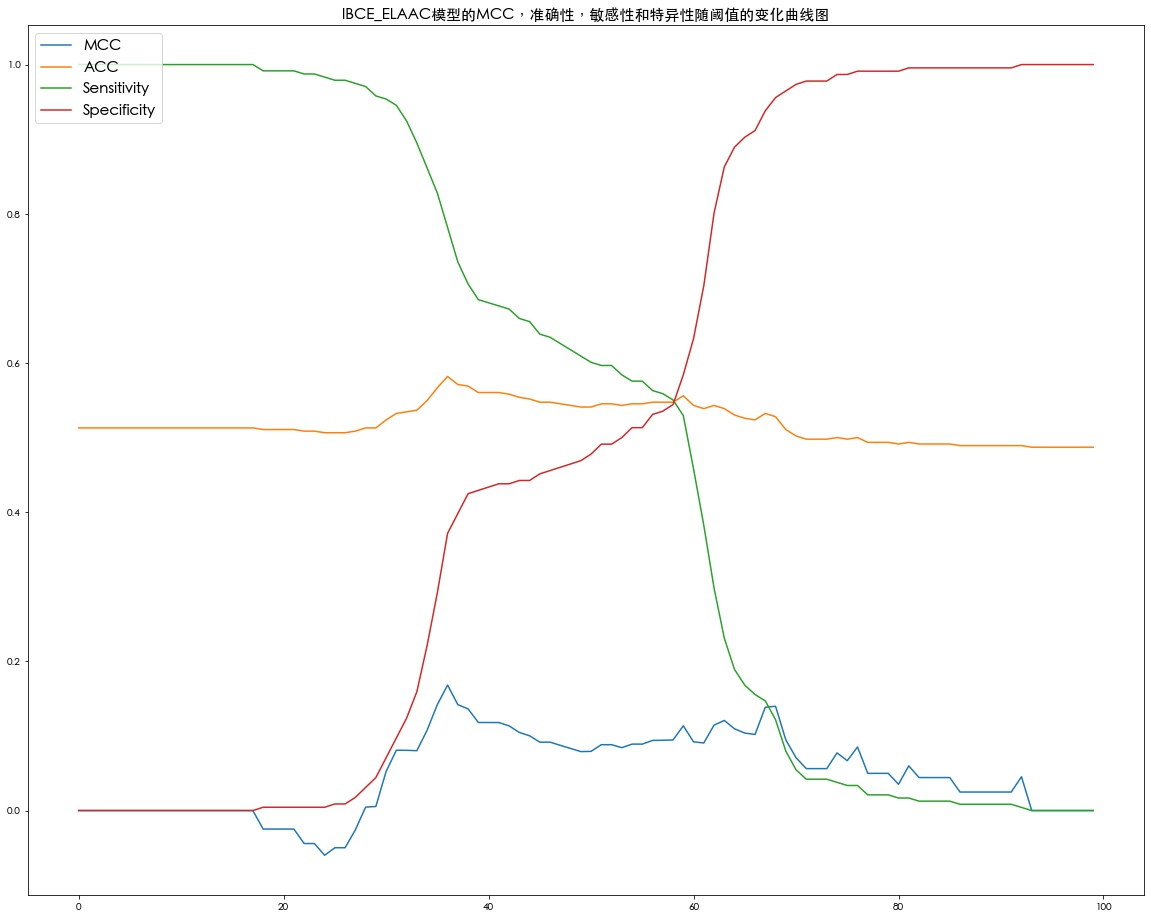

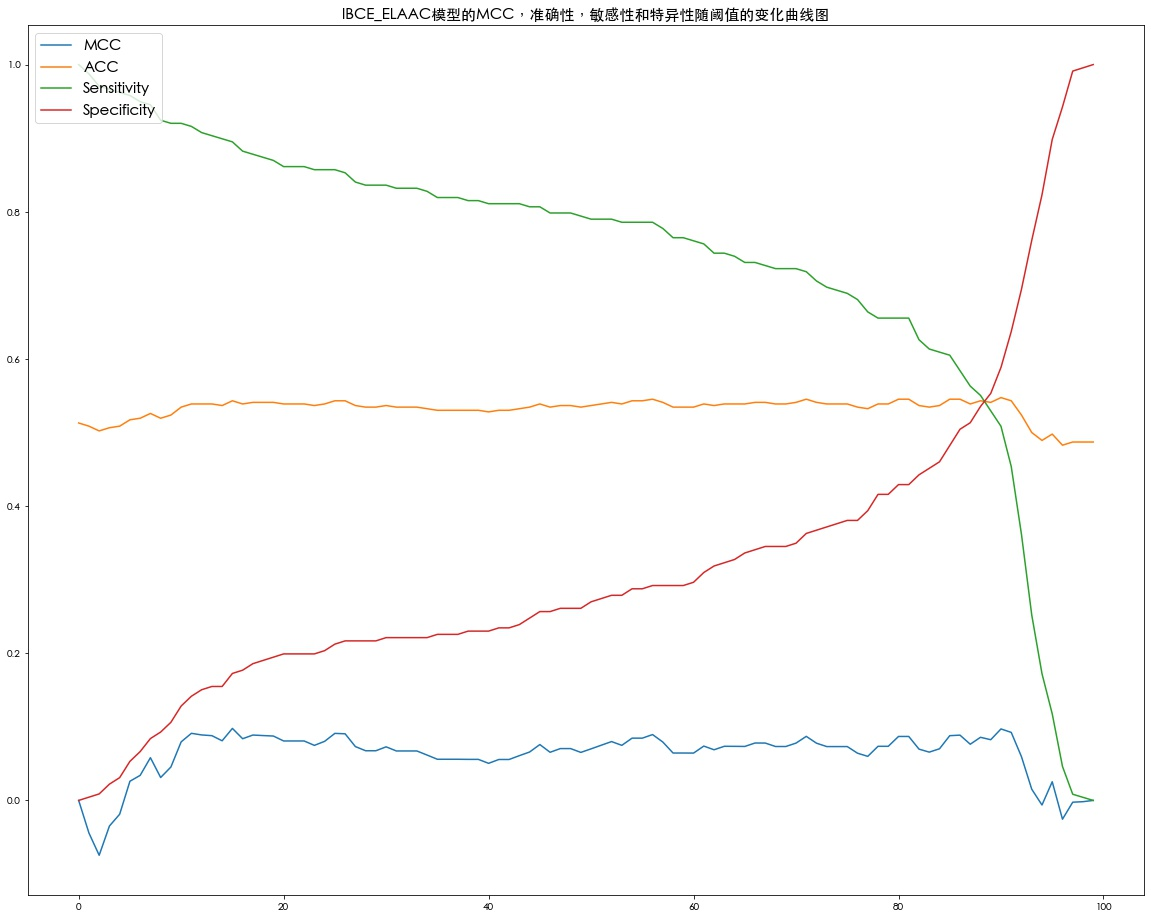

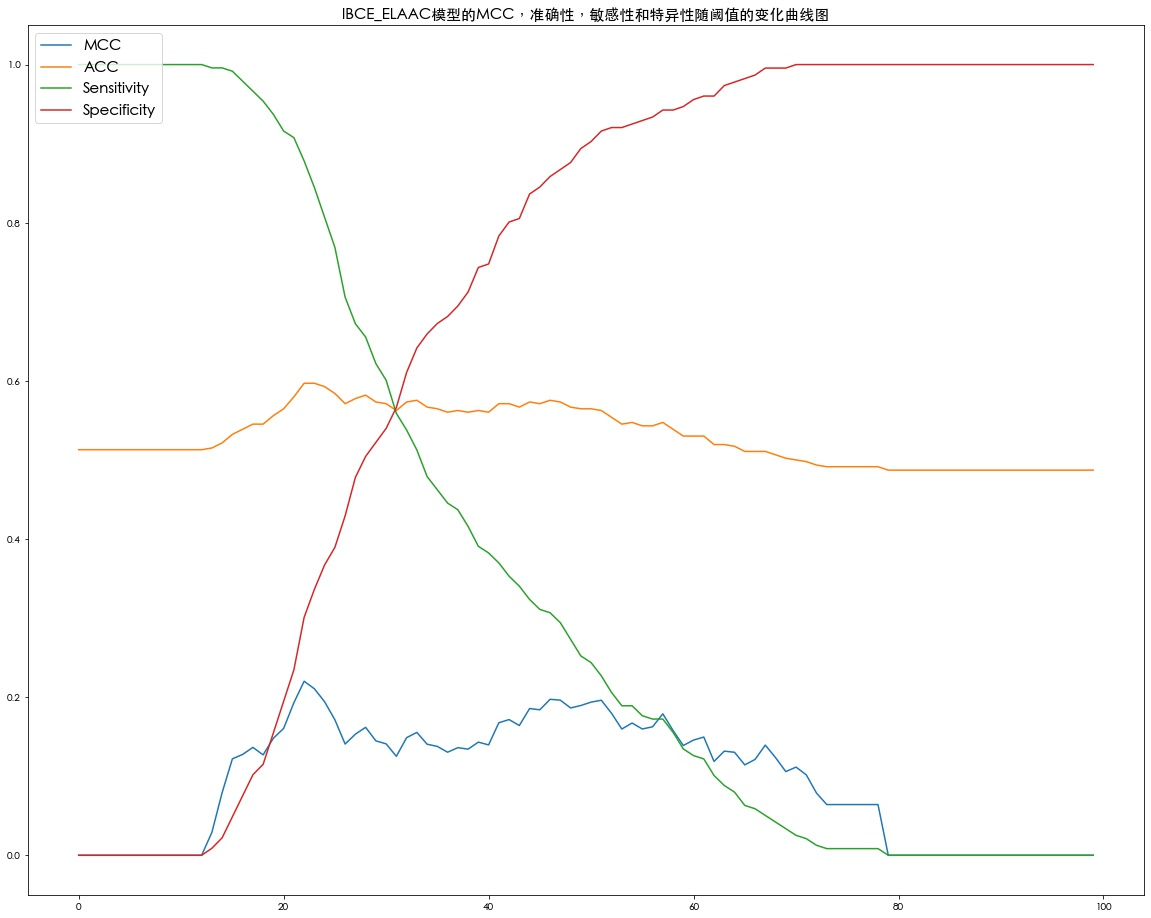

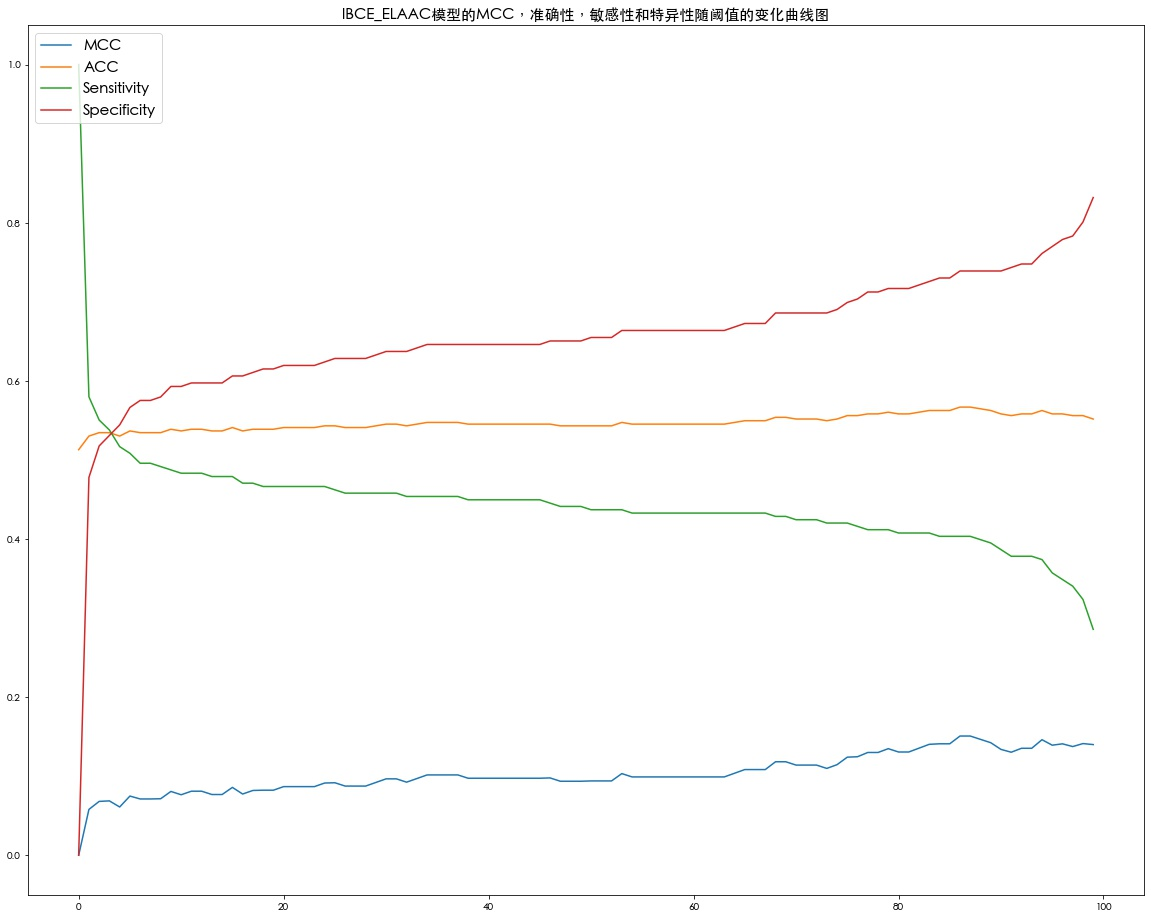

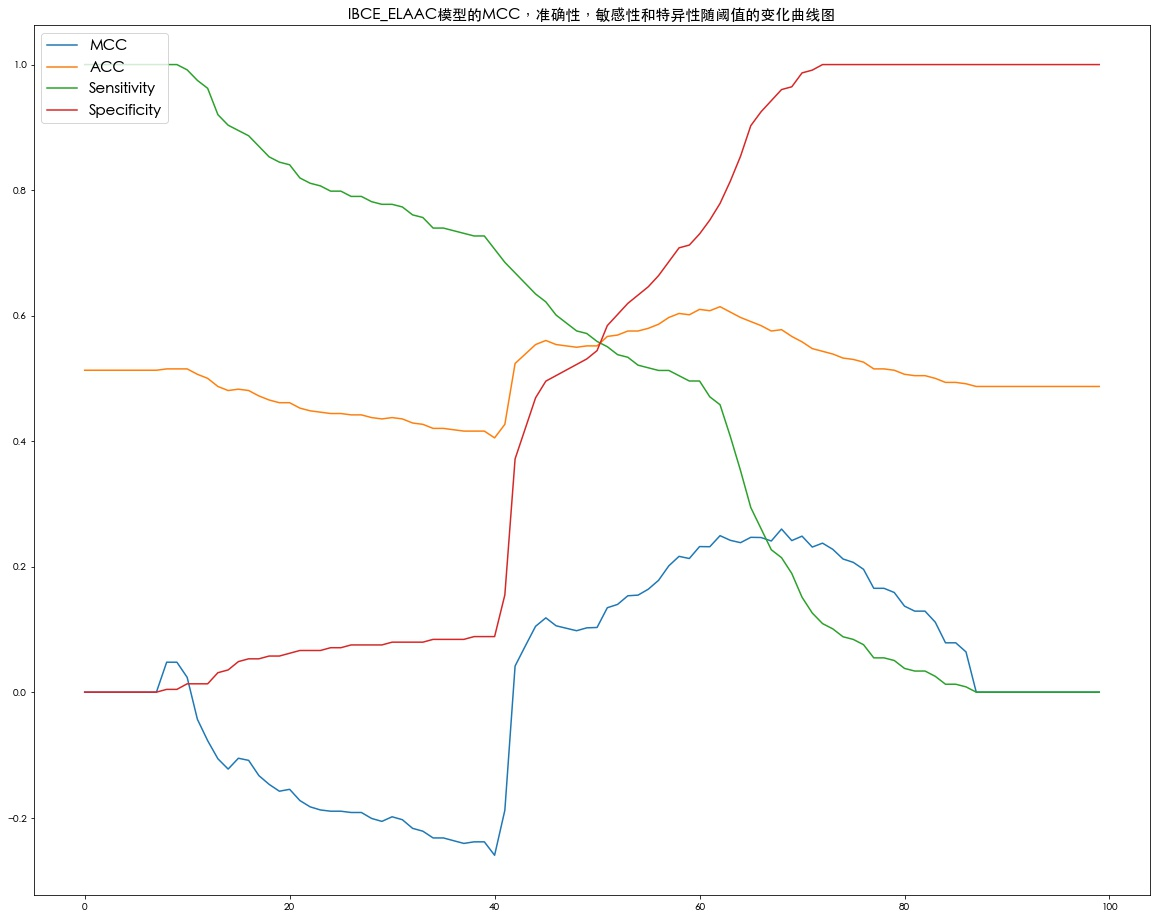

In [50]:
#在牛奶数据集上的评测
print('IBCE_ELAACModel模型的评估结果')
metricsEvaluate(milkAllergyTargets,Milk_AACProb,0.5)
drawMetrics(milkAllergyTargets,Milk_AACProb,'IBCE_ELAAC')


print('IBCE_ELDPCModel模型的评估结果')
metricsEvaluate(milkAllergyTargets,Milk_DPCProb,0.5)
drawMetrics(milkAllergyTargets,Milk_DPCProb,'IBCE_ELAAC')


print('IBCE_ELCTDModel模型的评估结果')
metricsEvaluate(milkAllergyTargets,Milk_CTDProb,0.5)
drawMetrics(milkAllergyTargets,Milk_CTDProb,'IBCE_ELAAC')


print('IBCE_ELAAIModel模型的评估结果')
metricsEvaluate(milkAllergyTargets,Milk_AAIProb,0.5)
drawMetrics(milkAllergyTargets,Milk_AAIProb,'IBCE_ELAAC')


print('IBCE_ELRNNModel模型的评估结果')
metricsEvaluate(milkAllergyTargets,Milk_RNNProb,0.5)
drawMetrics(milkAllergyTargets,Milk_RNNProb,'IBCE_ELAAC')


## EM模型评价
### EM1评价
EM1是5类模型的集合

79/79 [==============================] - 0s 802us/step - loss: 1.1189 - acc: 0.7403 - mae: 0.2711 - auc: 0.7954
IBCE_ELEMModel1模型的评估结果
模型的ACC为:0.74,
模型的敏感性为:0.74,
特异性为:0.74,
MCC系数为:0.48


/Users/xutingfeng/opt/anaconda3/envs/Bio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


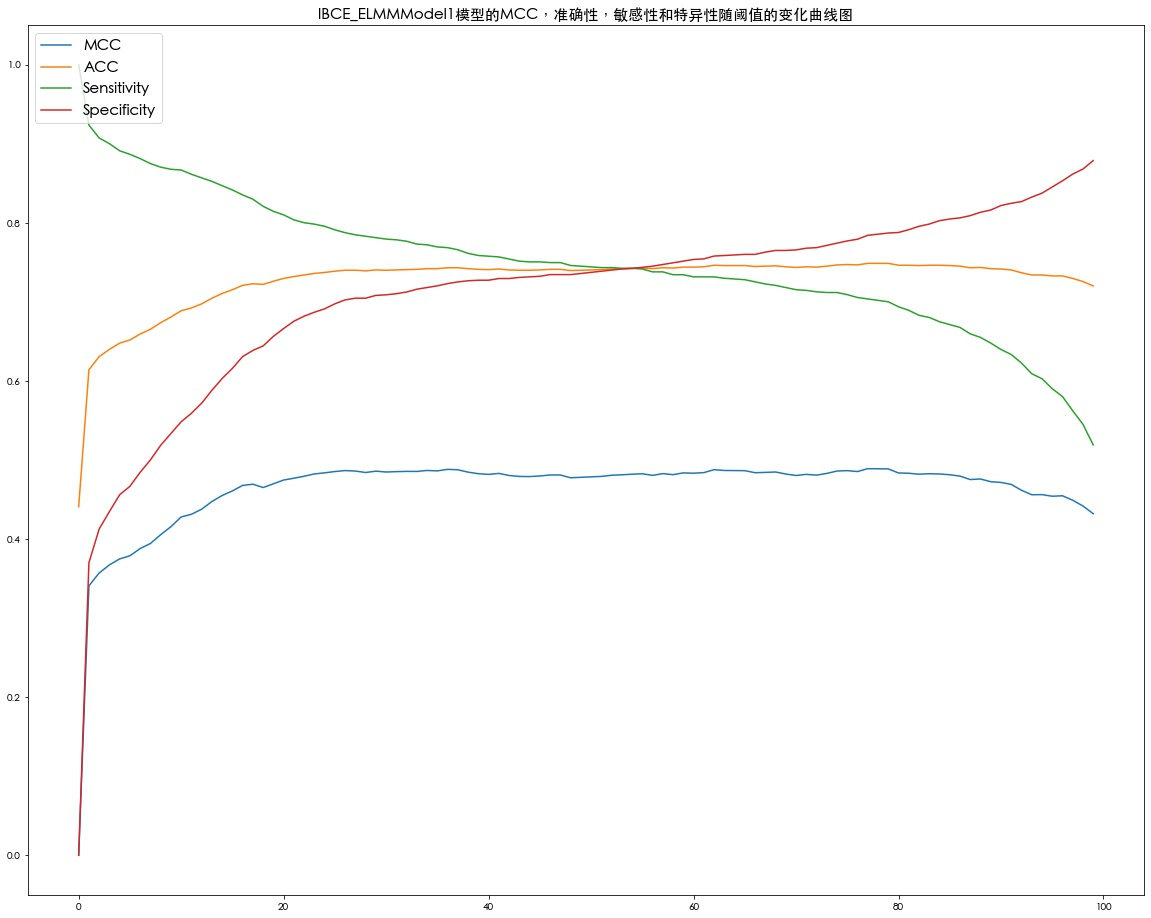

In [28]:
#评价EM1在IBCE-EL的独立数据集上的预测精度
IBCE_ELEMModel1.evaluate(x=np.concatenate([IBCE_ELAACProb,IBCE_ELDPCProb,IBCE_ELCTDProb,IBCE_ELAAIProb,IBCE_ELRNNProb],axis=1),
                        y = IBCE_ELTargets)

EM1Pred =IBCE_ELEMModel1.predict(x=np.concatenate([IBCE_ELAACProb,IBCE_ELDPCProb,IBCE_ELCTDProb,IBCE_ELAAIProb,IBCE_ELRNNProb],axis=1))  

print('IBCE_ELEMModel1模型的评估结果')
metricsEvaluate(IBCE_ELTargets,EM1Pred,0.5)
drawMetrics(IBCE_ELTargets,EM1Pred,'IBCE_ELMMModel1')

In [18]:
#评价EM1在牛奶过敏数据集上的预测精度
IBCE_ELEMModel1.evaluate(x=np.concatenate([Milk_AACProb,Milk_DPCProb,Milk_CTDProb,Milk_AAIProb,Milk_RNNProb],axis=1),
                        y = milkAllergyTargets)
EM1Pred =IBCE_ELEMModel1.predict(x=np.concatenate([Milk_AACProb,Milk_DPCProb,Milk_CTDProb,Milk_AAIProb,Milk_RNNProb],axis=1))  

print('IBCE_ELEMModel1模型在牛奶数据集上的评估结果')
metricsEvaluate(milkAllergyTargets,EM1Pred,0.5)
drawMetrics(milkAllergyTargets,EM1Pred,'IBCE_ELEMModel1')

NameError: name 'Milk_AACProb' is not defined

### EM2评价
EM是4类模型的集合（没有RNN）

79/79 [==============================] - 0s 739us/step - loss: 1.1040 - acc: 0.7391 - mae: 0.2700 - auc: 0.7929
IIBCE_ELEMModel2模型在IBCE-EL数据集上的评估结果
模型的ACC为:0.74,
模型的敏感性为:0.73,
特异性为:0.75,
MCC系数为:0.47


/Users/xutingfeng/opt/anaconda3/envs/Bio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


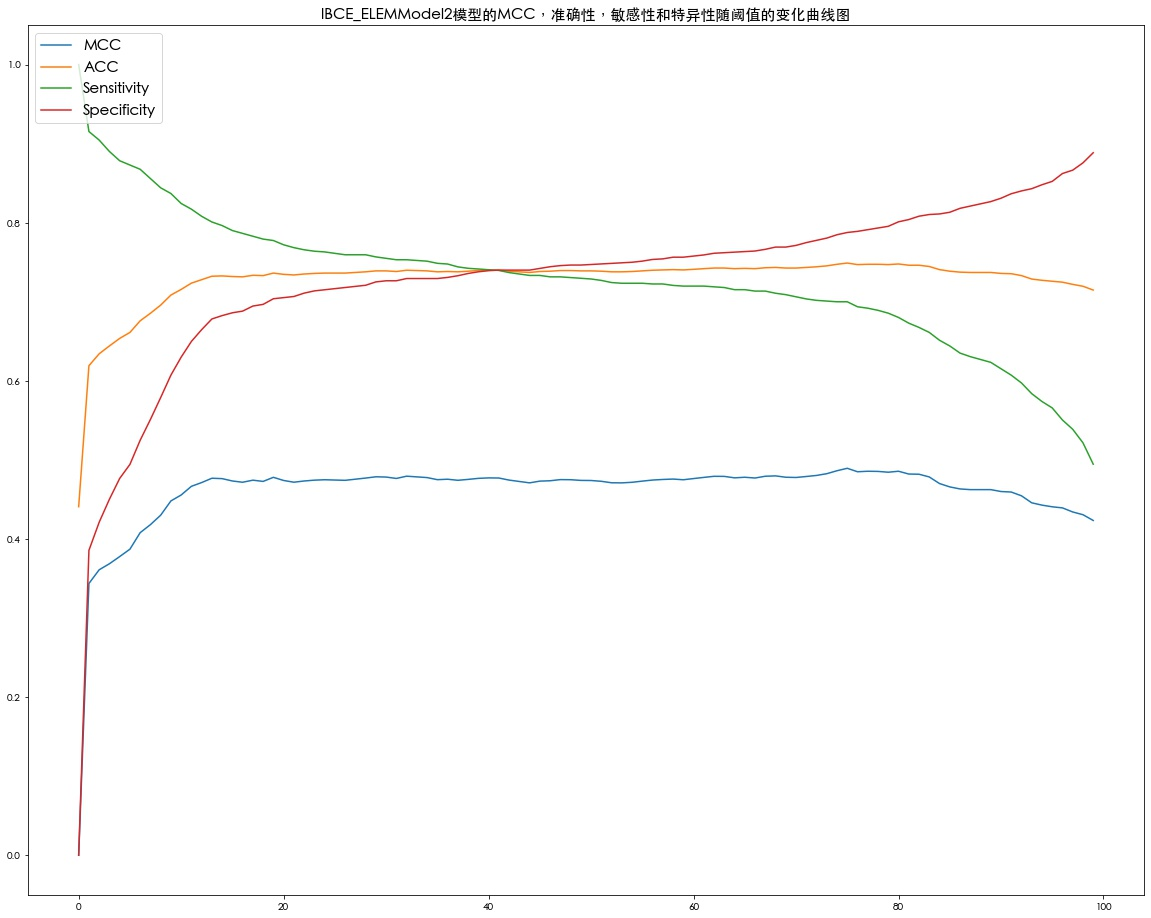

In [19]:
#评价EM2在IBCE-EL的数据上的预测精度
IBCE_ELEMModel2.evaluate(x=np.concatenate([IBCE_ELAACProb,IBCE_ELDPCProb,IBCE_ELCTDProb,IBCE_ELAAIProb],axis=1),
                        y = IBCE_ELTargets)

EM2Pred =IBCE_ELEMModel2.predict(x=np.concatenate([IBCE_ELAACProb,IBCE_ELDPCProb,IBCE_ELCTDProb,IBCE_ELAAIProb],axis=1))  

print('IIBCE_ELEMModel2模型在IBCE-EL数据集上的评估结果')
metricsEvaluate(IBCE_ELTargets,EM2Pred,0.5)
drawMetrics(IBCE_ELTargets,EM2Pred,'IBCE_ELEMModel2')

15/15 [==============================] - 0s 1ms/step - loss: 2.2146 - acc: 0.5474 - mae: 0.4509 - auc: 0.5681
IIBCE_ELEMModel2模型在IBCE-EL数据集上的评估结果
模型的ACC为:0.55,
模型的敏感性为:0.45,
特异性为:0.65,
MCC系数为:0.10


/Users/xutingfeng/opt/anaconda3/envs/Bio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


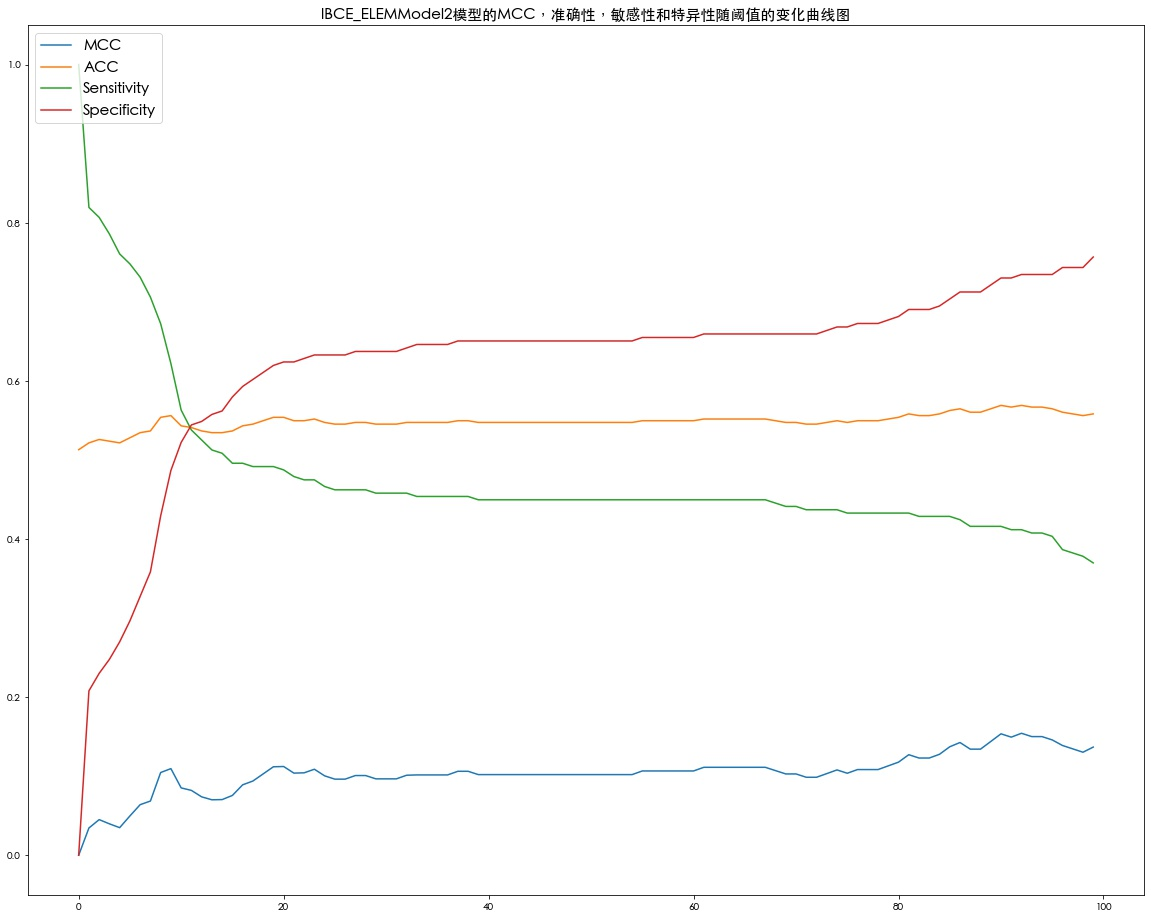

In [54]:
#评价EM2在牛奶过敏数据集上的预测精度
IBCE_ELEMModel2.evaluate(x=np.concatenate([Milk_AACProb,Milk_DPCProb,Milk_CTDProb,Milk_AAIProb],axis=1),
                        y = milkAllergyTargets)

EM2Pred =IBCE_ELEMModel2.predict(x=np.concatenate([Milk_AACProb,Milk_DPCProb,Milk_CTDProb,Milk_AAIProb],axis=1))  

print('IIBCE_ELEMModel2模型在IBCE-EL数据集上的评估结果')
metricsEvaluate(milkAllergyTargets,EM2Pred,0.5)
drawMetrics(milkAllergyTargets,EM2Pred,'IBCE_ELEMModel2')

# 对基于牛奶过敏数据的模型进行评价

In [351]:

#测试单个模型的性能
## 在牛奶过敏数据集上的效果
Milk_AACModel.evaluate(x=np.concatenate([milkAllergyBCEsFeatures[0],milkAllergynonBCEsFeatures[0]]),
                 y = milkAllergyTargets,batch_size=16)

Milk_DPCModel.evaluate(x=np.concatenate([milkAllergyBCEsFeatures[1],milkAllergynonBCEsFeatures[1]]),
                 y = milkAllergyTargets,batch_size=16)

Milk_CTDModel.evaluate(x=np.concatenate([milkAllergyBCEsFeatures[2],milkAllergynonBCEsFeatures[2]]),
                 y = milkAllergyTargets,batch_size=16)

Milk_AAIModel.evaluate(x=np.concatenate([milkAllergyBCEsFeatures[3],milkAllergynonBCEsFeatures[3]]),
                 y = milkAllergyTargets,batch_size=16)
Milk_RNNModel.evaluate(x=np.concatenate([milkAllergyBCEsFeatures[4],milkAllergynonBCEsFeatures[4]]),
                 y = milkAllergyTargets,batch_size=16)

29/29 [==============================] - 1s 2ms/step - loss: 0.8369 - acc: 0.7888 - auc: 0.8161


[0.8369380235671997, 0.7887930870056152, 0.8161486387252808]

In [22]:
## 在IBCE-EL数据集上的效果
Milk_AACModel.evaluate(x=np.concatenate([IBCE_PositiveFeatures[0],IBCE_NegativeFeatures[0]]),
                 y = IBCE_ELTargets,batch_size=64)

Milk_DPCModel.evaluate(x=np.concatenate([IBCE_PositiveFeatures[1],IBCE_NegativeFeatures[1]]),
                 y = IBCE_ELTargets,batch_size=64)

Milk_CTDModel.evaluate(x=np.concatenate([IBCE_PositiveFeatures[2],IBCE_NegativeFeatures[2]]),
                 y = IBCE_ELTargets,batch_size=64)

Milk_AAIModel.evaluate(x=np.concatenate([IBCE_PositiveFeatures[3],IBCE_NegativeFeatures[3]]),
                 y = IBCE_ELTargets,batch_size=64)

Milk_RNNModel.evaluate(x=np.concatenate([IBCE_PositiveFeatures[4],IBCE_NegativeFeatures[4]]),
                 y = IBCE_ELTargets,batch_size=64)

40/40 [==============================] - 1s 3ms/step - loss: 1.2268 - acc: 0.4873 - auc: 0.5715


[1.2268097400665283, 0.48729151487350464, 0.5714702606201172]

以下概率通过基于牛奶过敏数据的模型预测

In [23]:
###对单个模型的预测输出作为EM模型的输入
####生成IBCE-EL的5类模型输出
IBCE_ELAACProb = Milk_AACModel.predict(x=np.concatenate([IBCE_PositiveFeatures[0],IBCE_NegativeFeatures[0]]))

IBCE_ELDPCProb = Milk_DPCModel.predict(x=np.concatenate([IBCE_PositiveFeatures[1],IBCE_NegativeFeatures[1]]))

IBCE_ELCTDProb = Milk_CTDModel.predict(x=np.concatenate([IBCE_PositiveFeatures[2],IBCE_NegativeFeatures[2]]))

IBCE_ELAAIProb = Milk_AAIModel.predict(x=np.concatenate([IBCE_PositiveFeatures[3],IBCE_NegativeFeatures[3]]))

IBCE_ELRNNProb = Milk_RNNModel.predict(x=np.concatenate([IBCE_PositiveFeatures[4],IBCE_NegativeFeatures[4]]))



In [24]:
print('Milk_AACModel在IBCE-EL数据集上的评估结果')
metricsEvaluate(IBCE_ELTargets,IBCE_ELAACProb,0.5)
print('Milk_DPCModel在IBCE-EL数据集上的评估结果')
metricsEvaluate(IBCE_ELTargets,IBCE_ELDPCProb,0.5)
print('Milk_CTDModel在IBCE-EL数据集上的评估结果')
metricsEvaluate(IBCE_ELTargets,IBCE_ELCTDProb,0.5)
print('Milk_AAIModel在IBCE-EL数据集上的评估结果')
metricsEvaluate(IBCE_ELTargets,IBCE_ELAAIProb,0.5)
print('Milk_RNNModel在IBCE-EL数据集上的评估结果')
metricsEvaluate(IBCE_ELTargets,IBCE_ELRNNProb,0.5)

Milk_AACModel在IBCE-EL数据集上的评估结果
模型的ACC为:0.53,
模型的敏感性为:0.47,
特异性为:0.57,
MCC系数为:0.05
Milk_DPCModel在IBCE-EL数据集上的评估结果
模型的ACC为:0.45,
模型的敏感性为:0.95,
特异性为:0.05,
MCC系数为:-0.00
Milk_CTDModel在IBCE-EL数据集上的评估结果
模型的ACC为:0.49,
模型的敏感性为:0.84,
特异性为:0.22,
MCC系数为:0.08
Milk_AAIModel在IBCE-EL数据集上的评估结果
模型的ACC为:0.49,
模型的敏感性为:0.52,
特异性为:0.47,
MCC系数为:-0.01
Milk_RNNModel在IBCE-EL数据集上的评估结果
模型的ACC为:0.49,
模型的敏感性为:0.85,
特异性为:0.20,
MCC系数为:0.07


[0.4872915011914218,
 0.854954954954955,
 0.19744318181818182,
 0.06856763277677969]

In [352]:
####生成牛奶过敏数据集的5类模型输出
Milk_AACProb =Milk_AACModel.predict(x=np.concatenate([milkAllergyBCEsFeatures[0],milkAllergynonBCEsFeatures[0]]))
Milk_DPCProb =Milk_DPCModel.predict(x=np.concatenate([milkAllergyBCEsFeatures[1],milkAllergynonBCEsFeatures[1]]))
Milk_CTDProb =Milk_CTDModel.predict(x=np.concatenate([milkAllergyBCEsFeatures[2],milkAllergynonBCEsFeatures[2]]))
Milk_AAIProb =Milk_AAIModel.predict(x=np.concatenate([milkAllergyBCEsFeatures[3],milkAllergynonBCEsFeatures[3]]))
Milk_RNNProb =Milk_RNNModel.predict(x=np.concatenate([milkAllergyBCEsFeatures[4],milkAllergynonBCEsFeatures[4]]))




In [353]:
print('Milk_AACModel在Milk过敏数据集上的评估结果')
metricsEvaluate(milkAllergyTargets,Milk_AACProb,0.5)
print('Milk_DPCModel在Milk过敏数据集上的评估结果')
metricsEvaluate(milkAllergyTargets,Milk_DPCProb,0.5)
print('Milk_CTDModel在Milk过敏数据集上的评估结果')
metricsEvaluate(milkAllergyTargets,Milk_CTDProb,0.5)
print('Milk_AAIModel在Milk过敏数据集上的评估结果')
metricsEvaluate(milkAllergyTargets,Milk_AAIProb,0.5)
print('Milk_RNNModel在Milk过敏数据集上的评估结果')
metricsEvaluate(milkAllergyTargets,Milk_RNNProb,0.5)

Milk_AACModel在Milk过敏数据集上的评估结果
模型的ACC为:0.72,
模型的敏感性为:0.50,
特异性为:0.96,
MCC系数为:0.51
Milk_DPCModel在Milk过敏数据集上的评估结果
模型的ACC为:0.88,
模型的敏感性为:0.89,
特异性为:0.86,
MCC系数为:0.75
Milk_CTDModel在Milk过敏数据集上的评估结果
模型的ACC为:0.80,
模型的敏感性为:0.75,
特异性为:0.84,
MCC系数为:0.59
Milk_AAIModel在Milk过敏数据集上的评估结果
模型的ACC为:0.73,
模型的敏感性为:0.72,
特异性为:0.75,
MCC系数为:0.47
Milk_RNNModel在Milk过敏数据集上的评估结果
模型的ACC为:0.79,
模型的敏感性为:0.79,
特异性为:0.79,
MCC系数为:0.58


[0.7887931034482759,
 0.7899159663865546,
 0.7876106194690266,
 0.5774192448911658]

### 对EM模型进行评价
EM1 是5类模型的集合模型

EM2 是4类模型（不包括RNN）的集合模型

In [25]:
#评价EM1在IBCE-EL的数据上的预测精度
Milk_EMModel1.evaluate(x=np.concatenate([IBCE_ELAACProb,IBCE_ELDPCProb,IBCE_ELCTDProb,IBCE_ELAAIProb,IBCE_ELRNNProb],axis=1),
                        y = IBCE_ELTargets)

EM1Pred =Milk_EMModel1.predict(x=np.concatenate([IBCE_ELAACProb,IBCE_ELDPCProb,IBCE_ELCTDProb,IBCE_ELAAIProb,IBCE_ELRNNProb],axis=1))  

print('Milk_EMModel1模型在IBCE-EL数据集上的评估结果')
metricsEvaluate(IBCE_ELTargets,EM1Pred,0.5)

79/79 [==============================] - 0s 733us/step - loss: 1.7631 - acc: 0.4476 - mae: 0.5403 - auc: 0.5326
Milk_EMModel1模型在IBCE-EL数据集上的评估结果
模型的ACC为:0.45,
模型的敏感性为:0.96,
特异性为:0.05,
MCC系数为:0.01


[0.4475774424146148,
 0.9576576576576576,
 0.045454545454545456,
 0.007527161166205266]

In [354]:
#评价EM1在牛奶过敏数据集上的预测精度
Milk_EMModel1.evaluate(x=np.concatenate([Milk_AACProb,Milk_DPCProb,Milk_CTDProb,Milk_AAIProb,Milk_RNNProb],axis=1),
                        y = milkAllergyTargets)

EM1Pred =Milk_EMModel1.predict(x=np.concatenate([Milk_AACProb,Milk_DPCProb,Milk_CTDProb,Milk_AAIProb,Milk_RNNProb],axis=1))  

print('Milk_EMModel1模型在IBCE-EL数据集上的评估结果')
metricsEvaluate(milkAllergyTargets,EM1Pred,0.5)


15/15 [==============================] - 0s 1ms/step - loss: 0.2701 - acc: 0.8879 - mae: 0.1583 - auc: 0.9581
Milk_EMModel1模型在IBCE-EL数据集上的评估结果
模型的ACC为:0.89,
模型的敏感性为:0.90,
特异性为:0.88,
MCC系数为:0.78


[0.8879310344827587,
 0.8991596638655462,
 0.8761061946902655,
 0.7757274981105612]

In [344]:
#评价EM2在IBCE-EL的数据上的预测精度
Milk_EMModel2.evaluate(x=np.concatenate([IBCE_ELAACProb,IBCE_ELDPCProb,IBCE_ELCTDProb,IBCE_ELAAIProb],axis=1),
                        y = IBCE_ELTargets)
EM2Pred =Milk_EMModel2.predict(x=np.concatenate([IBCE_ELAACProb,IBCE_ELDPCProb,IBCE_ELCTDProb,IBCE_ELAAIProb],axis=1))  

print('Milk_EMModel2模型在IBCE-EL数据集上的评估结果')
metricsEvaluate(IBCE_ELTargets,EM2Pred,0.5)


311/311 [==============================] - 0s 712us/step - loss: 1.7430 - acc: 0.4546 - mae: 0.5324 - auc: 0.5488
Milk_EMModel2模型在IBCE-EL数据集上的评估结果
模型的ACC为:0.45,
模型的敏感性为:0.97,
特异性为:0.04,
MCC系数为:0.02


[0.4546095717884131,
 0.9671171171171171,
 0.03974475843208751,
 0.018151824639332927]

In [355]:
#评价EM2在牛奶过敏数据集上的预测精度
Milk_EMModel2.evaluate(x=np.concatenate([Milk_AACProb,Milk_DPCProb,Milk_CTDProb,Milk_AAIProb],axis=1),
                        y = milkAllergyTargets)


EM2Pred =Milk_EMModel2.predict(x=np.concatenate([Milk_AACProb,Milk_DPCProb,Milk_CTDProb,Milk_AAIProb],axis=1))  

print('Milk_EMModel2模型在IBCE-EL数据集上的评估结果')
metricsEvaluate(milkAllergyTargets,EM2Pred,0.5)

15/15 [==============================] - 0s 969us/step - loss: 0.2716 - acc: 0.8901 - mae: 0.1622 - auc: 0.9574
Milk_EMModel2模型在IBCE-EL数据集上的评估结果
模型的ACC为:0.89,
模型的敏感性为:0.91,
特异性为:0.87,
MCC系数为:0.78


[0.8900862068965517, 0.907563025210084, 0.8716814159292036, 0.780209638835228]